## Denoising Diffusion Probabilistic Models

This notebook is a minimalistic implementation of the [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) paper.  The paper has been used to great effect for generating realistic images while also avoiding the mode collapse problems often seen in GANs.  To keep things simple we will be using the MNIST dataset. The method involves training a CNN to predict the noise component in a partially corrupted image.  At inference time we apply this CNN to pure white noise, the predicted noise component is subtracted from the input, renoised, and the result is feed into the network again.  We repeat this for a large number of steps (1000 in this notebook) to generate a new image modelled after the training data. The CNN architecure is somewhat arbitrary, but following the paper we will use a modified version of U-Net.

## Setup

In [1]:
#!pip install -q diffusers

In [2]:
import torch
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import diffusers
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = type('Config', (), {'image_size': 28, 'timesteps': 1000, 'beta_start': 0.0001, 'beta_end': 0.02})()

## Model

The neural network architectures we will use is a UNet with three downsampling blocks and three upsampling blocks. We will creates this network using the diffusers library and you can change its archicture via the config variable. For example, you change the depth of the network using the layers_per_block option, which controls the number of layer for each of the up/down blocks.

This exact architecture is also commonly used for diffusion models.  Here is an example of UNet architecture, this diagram differs from our architecture in some ways, but the general structure is the same.

<img src="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png" width="540">

In [4]:
# Model
model = diffusers.UNet2DModel(
    sample_size=config.image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D"),
).to(device)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Dataset

First we download and plot the training data.

In [5]:
# Data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.53MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 58.0kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.28MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.79MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



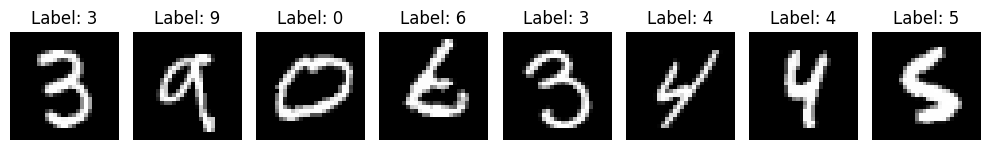

In [6]:
# Get a batch of images
images, labels = next(iter(dataloader))

# Create a 2x2 subplot
fig, axes = plt.subplots(1, 8, figsize=(10, 6))

# Display 4 images
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.axis('off')
    ax.set_title(f'Label: {labels[i].item()}')

plt.tight_layout()
plt.show()

## Noise Schedule

How do we add noise to these MNIST images?  Over $T=1000$ time steps $t$, we gradually add Gaussian noise. We call this the forward process and model it using $q(x_t|x_{t-1})$ where $x_t$ is an image at time step $t$.  So at time $x_0$ we have an MNIST image uncorrupted by noise, at $x_{483}$ we have an MNIST image that is mixed with noise, and at $x_{1000}$ we have pure noise.

To add this noise we will use a linear schedule controlled by parameter $\beta=0.0001...0.02$

$$ q(x_t|x_{t-1})=\mathcal{N}(\sqrt{1-\beta_t}x_{t-1}, \beta_t\boldsymbol{I})$$

However, we have a problem.  To calculate $x_{1000}$ would would need to apply this formular recursivly 1000 times!  So to simplify this we can rewrite it as

$$ q(x_t|x_0)=\mathcal{N}(\sqrt{\bar{\alpha_t}}x_0, (1-\bar{\alpha_t})\boldsymbol{I})$$

where
$$\alpha_t=1-\beta_t$$
$$\bar{\alpha_t}=\prod_{s=1}^t{\alpha_s}$$

These values are computed below and will be very important during both training sampling.

In [7]:
# Noise schedule
betas = torch.linspace(config.beta_start, config.beta_end, config.timesteps).to(device)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

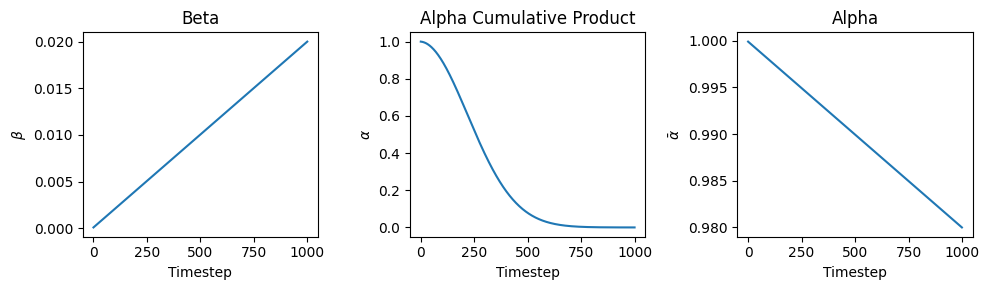

In [8]:
# Display noise schedule values
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

ax1.plot(betas.cpu().numpy())
ax1.set_xlabel("Timestep")
ax1.set_title("Beta")
ax1.set_ylabel(r'$\beta$')

ax2.plot(alphas_cumprod.cpu().numpy())
ax2.set_xlabel("Timestep")
ax2.set_title("Alpha Cumulative Product")
ax2.set_ylabel(r'$\alpha$')

ax3.plot(alphas.cpu().numpy())
ax3.set_xlabel("Timestep")
ax3.set_title("Alpha")
ax3.set_ylabel(r'$\bar{\alpha}$')

plt.tight_layout()
plt.show()

## Training

The block of code below sets up hyperparameters, a dataloader and an Adam optimizer.  It then executes the following algorithm. In order to train our denoising CNN, we execute the following simple algorithm where $ϵ_{\theta}$ is our neural network.

1. $~~\text{repeat}$
2. $~~~~~~x_0 \sim q(x_0)$
3. $~~~~~~t \sim \text{Uniform}(\{1...T\})$
4. $~~~~~~ϵ \sim \mathcal{N}(0,I)$
5. $~~~~~~\text{taking gradient descent step on}$
6. $~~~~~~~~~~~∇_{θ}||ϵ-ϵ_{\theta}(\bar{\alpha_t}x_0+\sqrt{1-\bar{\alpha_t}}ϵ, t)||$
7. $~~~~~~\text{until convergence}$


In [9]:
def train_step(x, t):
    # Mix random Gaussian noise with images
    noise = torch.randn_like(x)
    noisy_x = torch.sqrt(alphas_cumprod[t])[:, None, None, None] * x + \
            torch.sqrt(1 - alphas_cumprod[t])[:, None, None, None] * noise

    # Run the denoising neural network
    noise_pred = model(noisy_x, t).sample

    # Return mean squared error loss
    return F.mse_loss(noise_pred, noise)

In [10]:
# Define hyper parameters
learning_rate = 1e-4
total_epochs = 10

# Define optimization algorithm
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Run training loop
loss_history = []
for epoch in range(total_epochs):
    total_loss = 0.0
    for step, data in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Sample random MNIST images
        x = data[0].to(device)

        # Sample a random timestep (between 0 and 1000)
        t = torch.randint(0, config.timesteps, (x.shape[0],)).to(device)

        # Run neural network and calculate loss
        loss = train_step(x, t)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record loss
        total_loss += loss.item()
    total_loss /= len(dataloader)
    loss_history.append(total_loss)
    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 0, Loss: 0.0421


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 1, Loss: 0.0265


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 2, Loss: 0.0248


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 3, Loss: 0.0241


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 4, Loss: 0.0235


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 5, Loss: 0.0232


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 6, Loss: 0.0228


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 7, Loss: 0.0226


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]


Epoch 8, Loss: 0.0223


100%|██████████| 938/938 [04:55<00:00,  3.17it/s]

Epoch 9, Loss: 0.0222


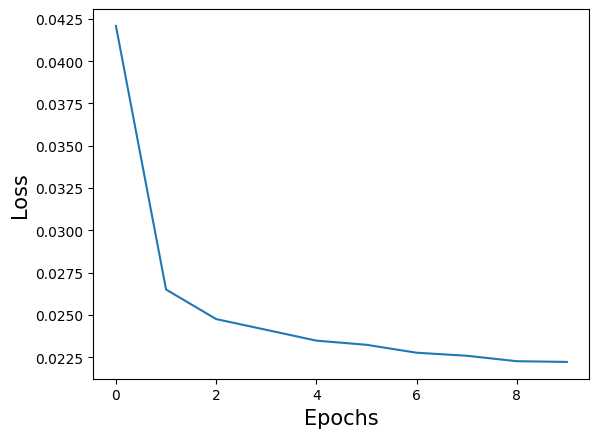

In [11]:
plt.plot(loss_history)
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.show()

## Sampling

Here we sample (or generate) a batch of 64 images. We will use the [Denoising Diffusion Implicit Models (DDIM)](https://arxiv.org/abs/2010.02502) formula to generate our images as it allows to skip steps, thereby generating our image faster. This can be done using the following algorithm

1. $~~x_T \sim \mathcal{N}(0,I)$
2. $~~\text{for}~t=1...T~\text{do}$
3. $~~~~~~x_{t-1}=\sqrt{\alpha_{t-1}} \left(\frac{x_t - \sqrt{1-\alpha_t} ϵ_{\theta}(x_t,t)}{\sqrt{\alpha_t}}\right) + \sqrt{1 - \alpha_{t-1}}ϵ_{\theta}(x_t,t)$
4. $~~\text{end for}$
5. $~~\text{return}~x_0$

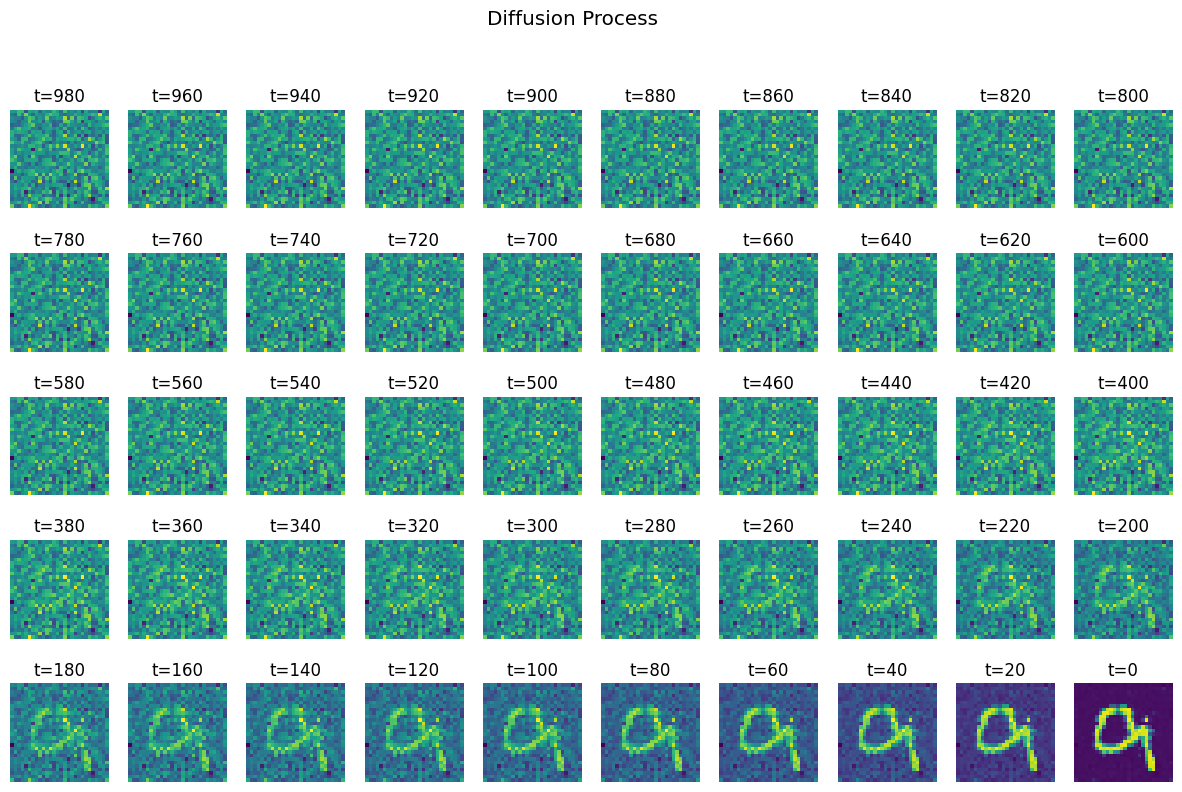

In [12]:
# Initalize plots
fig, axs = plt.subplots(5, 10, figsize=(15,9))
fig.suptitle("Diffusion Process", fontsize="x-large")

# Create starting noise
image_size = 28
batch_size = 64
x = torch.randn(batch_size, 1, image_size, image_size).to(device)

# Inference : Markov chain with T steps
for i in reversed(range(config.timesteps)):

    # Get the correct shape for timesteps t
    t = torch.full((x.shape[0],), i, dtype=torch.long).to(device)

    # Run neural network
    with torch.no_grad():
        predicted_noise = model(x, t).sample

    # Equation 12 - Denoising Diffusion Implicit Models (https://arxiv.org/pdf/2010.02502)
    alpha_cumprod = alphas_cumprod[t][:, None, None, None]
    alpha_cumprod_minus_1 = (torch.tensor(1.0) if i == 0 else alphas_cumprod[t-1][:, None, None, None])
    x = torch.sqrt(alpha_cumprod_minus_1) * ((x - torch.sqrt(1 - alpha_cumprod) * predicted_noise) / torch.sqrt(alpha_cumprod)) + \
        torch.sqrt(1 - alpha_cumprod_minus_1) * predicted_noise

    # Display image for each timestep
    if i % 20 == 0:
        x = x.detach().cpu()
        idx = (config.timesteps // 20) - (i // 20) - 1
        axs[int(idx / 10), int(idx % 10)].imshow((x[0,0] + 1) / 2)
        axs[int(idx / 10), int(idx % 10)].axis('off')
        axs[int(idx / 10), int(idx % 10)].set_title('t='+str(t[0].item()))
        x = x.to(device)


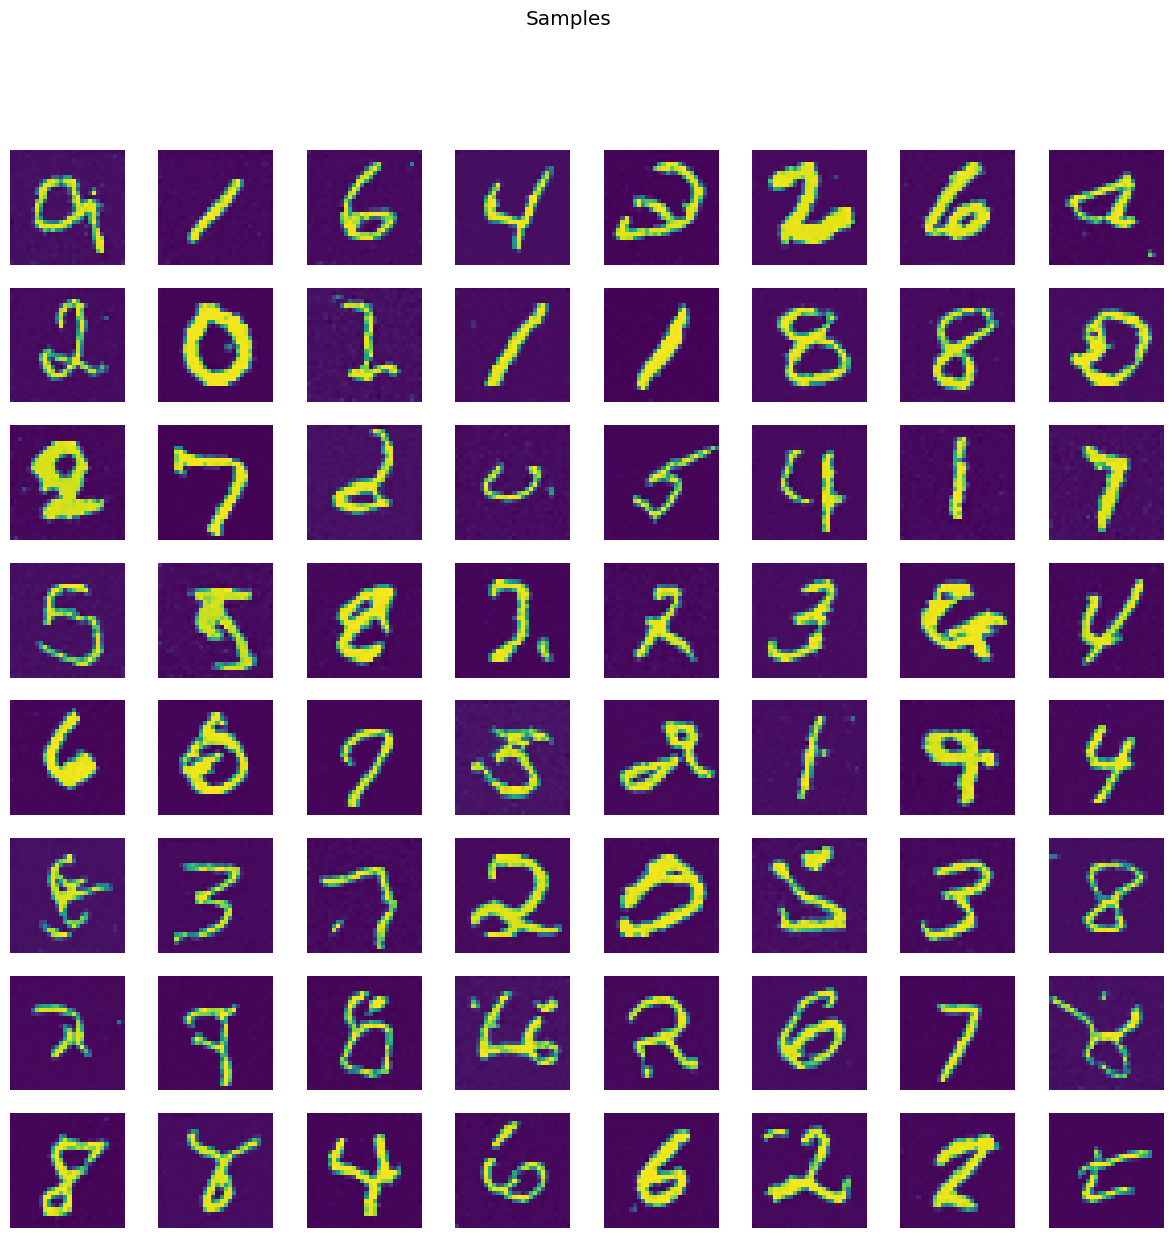

In [13]:
# Normalize image results
img_copy = x.clone().detach()
img_copy = img_copy.cpu().numpy()
img_copy = (img_copy + 1) / 2

# Initalize plots
fig, axs = plt.subplots(8, 8, figsize=(15,14))
fig.suptitle("Samples", fontsize="x-large")

# Plot all images in the batch
for i in range(batch_size):
  axs[int(i / 8), int(i % 8)].imshow(img_copy[i,0,:,:])
  axs[int(i / 8), int(i % 8)].axis('off')

## Appendix

[This video](https://www.youtube.com/watch?v=HoKDTa5jHvg&t=946s) has a very good section about the maths derivations in this paper.

### Reverse Process

The forward process was mentioned in the **Data** section, but we also have the reverse process $p_{\theta}(x_{0:T})$ which can be thought of as a Markov chain. This is defined as

$$ p_{\theta}(x_{0:T}) = p_{\theta}(x_{T})∏_{t=1}^T{p_{\theta}(x_{t-1}|x_{t})} $$

where

$$ p_{\theta}(x_{T}) = \mathcal{N}(0,I)$$
$$ p_{\theta}(x_{t-1}|x_{t}) = \mathcal{N}(\mu_{\theta}(x_t,t), \Sigma_{\theta}(x_t,t))$$

Our functions $\mu_{\theta}$ and $\Sigma_{\theta}$ calculate the mean and variance of the normal distribution respectivly.  Because of our noise schedule the variance function is simply $\Sigma_{\theta}(x_t,t)=\beta_tI$.  Our mean function $\mu_{\theta}(x_t,t)$ is approximated using a neural network.  This is the neural network we trained in the above sections.  



### Loss Function
To optimise the neural network described above we need to minimize negative log likelihood

$$ -\text{log}(p_{\theta}(x_0)) $$

However, this value is not easily computable so we optimise a variational lower bound instead. This variation lower bound is created by adding the KL divergence $D_{KL}$, which measures the similarity between two distributions and is always positive.

$$ -\text{log}(p_{\theta}(x_0)) \le -\text{log}(p_{\theta}(x_0)) + D_{KL}(q(x_{1:T}|x_0)||p_{\theta}(x_{1:T}|x_0)) = L_{VLB}$$

which, after a lot of algebra, can be reformulated as

$$ L_{VLB} = D_{KL}(q(x_{T}|x_0)||p(x_{T})) + \sum_{t \ge 1} {D_{KL}(q(x_{t-1}|x_t,x_0)||p_{\theta}(x_{t-1}|x_t))-\text{log}p_{\theta}(x_0|x_1)} $$

The first term here is the KL divergence between two similar normal distributions, meaning it will be very small and can therefore be ignored

$$ L_{VLB} = \sum_{t \ge 1} {D_{KL}(q(x_{t-1}|x_t,x_0)||p_{\theta}(x_{t-1}|x_t))-\text{log}p_{\theta}(x_0|x_1)} $$

To both simplify the maths and improve sample quality, the authors changed this into our final simplified loss function

$$ L_{simple} = \left|\left| ϵ - \epsilon_{\theta}\left(\sqrt{\bar{\alpha_t}}x_0+\sqrt{1-\bar{\alpha_t}} ϵ ,t\right) \right|\right|^2 $$

where

$ ~~~~~~~~~~~~ t=$ time step

$ ~~~~~~~~~~~~ ϵ = $ noise

$ ~~~~~~~~~~~~ ϵ_{\theta} = $ neural network

$ ~~~~~~~~~~~~ \bar{\alpha_t}=$  (see **Data** section)

$ ~~~~~~~~~~~~ x_0=$ uncorrupted image


